# Fantasy baseball draft - Lahman data

The purpose of this document is to prepare data for my fantasy baseball draft with Will. I will develop a scoring algorithm whose result should be correlated with the league's winning conditions , and then attempt to run machine learning on it to find other markers that might help us maximize the score.

Two separate models will be needed; one for hitters and another for pitchers, as each are judged by different criteria (naturally).

The data is from the latest version of the Lahman database. Each row is a player-season, for the 2011-2016 seasons.

## Winning criteria - hitters
Each week the league's teams are ranked 1-10 based on their performance in each of five player statistics:

* Batting average
* Home runs
* Runs scored
* Runs batted in
* Stolen bases

The top ranked team scores 10 points, the second-ranked scores 9, and so on.

## Import needed libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

## Import the hitters data

In [2]:
hitters = pd.read_csv("hitterdata.csv", header=0)

In [3]:
hitters.head()

,playerID,yearID,LastOfteamID,nameFirst,nameLast,weight,height,bats,lgID,G,...,G_2b,G_3b,G_ss,G_lf,G_cf,G_rf,G_of,G_dh,debut,birthCountry
0,abreujo02,2014,CHA,Jose,Abreu,255,75,R,AL,145.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,2014-03-31,Cuba
1,abreujo02,2015,CHA,Jose,Abreu,255,75,R,AL,154.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,2014-03-31,Cuba
2,abreujo02,2016,CHA,Jose,Abreu,255,75,R,AL,159.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,2014-03-31,Cuba
3,ackledu01,2015,NYA,Dustin,Ackley,205,73,L,AL,23.0,...,1.0,0.0,0.0,0.0,0.0,9.0,9.0,3.0,2011-06-17,USA
4,ackledu01,2016,NYA,Dustin,Ackley,205,73,L,AL,28.0,...,1.0,0.0,0.0,0.0,0.0,9.0,9.0,3.0,2011-06-17,USA


In [4]:
hitters.columns

Index(['playerID', 'yearID', 'LastOfteamID', 'nameFirst', 'nameLast', 'weight',
       'height', 'bats', 'lgID', 'G', 'H', 'AB', 'HR', 'RBI', 'SB', 'R', '2B',
       '3B', 'CS', 'BB', 'SO', 'IBB', 'HBP', 'SH', 'SF', 'GIDP', 'G_p', 'G_c',
       'G_1b', 'G_2b', 'G_3b', 'G_ss', 'G_lf', 'G_cf', 'G_rf', 'G_of', 'G_dh',
       'debut', 'birthCountry'],
      dtype='object')

## Eligibility criteria

Under league rules, players are eligible to be selected "at their primary position, plus positions they've played 10 games last year or 1 game this year." For the draft, we need to figure out what these are. Since I have no source for "primary position", I will assume the position at which a player has played the most games is his primary position. We need to construct a function to identify these.

In [5]:
hitters.columns

Index(['playerID', 'yearID', 'LastOfteamID', 'nameFirst', 'nameLast', 'weight',
       'height', 'bats', 'lgID', 'G', 'H', 'AB', 'HR', 'RBI', 'SB', 'R', '2B',
       '3B', 'CS', 'BB', 'SO', 'IBB', 'HBP', 'SH', 'SF', 'GIDP', 'G_p', 'G_c',
       'G_1b', 'G_2b', 'G_3b', 'G_ss', 'G_lf', 'G_cf', 'G_rf', 'G_of', 'G_dh',
       'debut', 'birthCountry'],
      dtype='object')

In [6]:
gamescols = ['G_p', 'G_c', 'G_1b', 'G_2b', 'G_3b', 'G_ss', 'G_lf', 'G_cf', 'G_rf', 'G_of', 'G_dh']

In [7]:
hitters[gamescols].max(axis = 1)

0       152.0
1       152.0
2       152.0
3        13.0
4        13.0
5        47.0
6        47.0
7        47.0
8        86.0
9        86.0
10       86.0
11       86.0
12       86.0
13       13.0
14       13.0
15       13.0
16       13.0
17        7.0
18        7.0
19        7.0
20       88.0
21       88.0
22       88.0
23       11.0
24       11.0
25        5.0
26        4.0
27       58.0
28       58.0
29       41.0
        ...  
1455     88.0
1456     88.0
1457     88.0
1458      6.0
1459     36.0
1460     36.0
1461     36.0
1462     36.0
1463     36.0
1464     36.0
1465    149.0
1466    149.0
1467    149.0
1468    149.0
1469      2.0
1470      2.0
1471      2.0
1472     69.0
1473      4.0
1474    114.0
1475    114.0
1476    114.0
1477    114.0
1478    114.0
1479    114.0
1480    119.0
1481     52.0
1482     52.0
1483     52.0
1484     52.0
dtype: float64

In [8]:
prim_pos_index = np.argmax(hitters[gamescols].as_matrix(), axis=1)

In [9]:
# for 1 to number of hitters:
#    get position of max games played out of all positions played
#   use position to identify position
#   store position in 'prim_pos' column
prim_pos = []
for i in range(len(hitters)):
    prim_pos.append(gamescols[prim_pos_index[i]][2:])
hitters['prim_pos'] = prim_pos

Now I need to find other eligible positions. 
1. For each player, find the gamescols where their games played is >=10.
2. Combine these into a string rep and store in 'other_pos'.

In [10]:
test = hitters.iloc[178,]

In [11]:
np.where(test[gamescols]>10)[0].tolist()

[7, 9]

In [12]:
list(gamescols[i][2:] for i in np.where(test[gamescols]>10)[0].tolist())

['cf', 'of']

In [13]:
def findOtherPositions(x):
    other_pos = list(gamescols[i][2:] for i in np.where(x[gamescols]>=10)[0].tolist())
    return other_pos

In [14]:
hitters['other_pos'] = hitters.apply(findOtherPositions, axis=1)

In [15]:
findOtherPositions(hitters.iloc[178,])

['cf', 'of']

In [16]:
# Check row 178 - it works!
hitters.iloc[178,]

playerID         burnsbi02
yearID                2016
LastOfteamID           KCA
nameFirst            Billy
nameLast             Burns
weight                 170
height                  69
bats                     B
lgID                    AL
G                       97
H                       73
AB                     311
HR                       0
RBI                     13
SB                      17
R                       39
2B                      11
3B                       4
CS                       5
BB                      10
SO                      37
IBB                      2
HBP                      6
SH                       3
SF                       2
GIDP                     3
G_p                      0
G_c                      0
G_1b                     0
G_2b                     0
G_3b                     0
G_ss                     0
G_lf                     6
G_cf                    80
G_rf                     7
G_of                    87
G_dh                     4
d

I now have each player's primary position (assumed to be the one they played the most games at during 2016) and each position for which they are eligible (played at least 10 games at during 2016).

## Calculating any other desired statistics

I will also calculate any necessary statistics. Statistics I calculate are as follows:

* Batting average
* On-base percentage
* Slugging percentage (which is not really a percentage)
* OPS (on-base plus slugging)
* wOBA

In [17]:
# Batting average
hitters['BA'] = hitters['H'] / hitters['AB']

In [18]:
# On-base percentage = (hits + walks + hbp) / (atbats + walks + hbps + sac flies)
hitters['OBP'] = (hitters['H']+hitters['BB']+hitters['HBP']) / (hitters['AB']+hitters['BB']+hitters['HBP']+hitters['SF'])

In [19]:
# Slugging percentage = (1*singles + 2*doubles + 3*triples + 4*HR) / AB
# First we need number of singles
hitters['1B'] = hitters['H'] - hitters['2B'] - hitters['3B'] - hitters['HR']
hitters['SLG'] = (hitters['1B'] + 2 * hitters['2B'] + 3 * hitters['3B'] + 4*hitters['HR']) / hitters['AB']

In [20]:
# On-base + slugging
hitters['OPS'] = hitters['OBP'] + hitters['SLG']

Having done that, I need to figure out how to separate these into years, and then calculate the *adjusted fantasy star rating*, which consists of the following steps:

* For each year, index each of the five statistics, so that the league leader (without regard to games played / at bats) is at a 1.0, and the poorest performer is at 0.0.
* Apply a penalty to each statistic based on the number of games played / at bats. This penalty can be a very small number (harsh penalty), but shouldn't be 0.
* Sum each index statistic and apply the penalty. Therefore, the maximum rating is five stars, but that can only be achieved by someone who led the league in all five statistics while simultaneously having more games played / at bats than anyone else.

I will then show analytics on the scores, to rank the available players. Those who have higher scores should contribute more positively to the success of our team.

In [21]:
hitters['BA_Scaled'] = hitters.groupby("yearID")['BA'].apply(lambda x: (x-min(x))/(max(x)-min(x)))

In [22]:
hitters['HR_Scaled'] = hitters.groupby("yearID")['HR'].apply(lambda x: (x-min(x))/(max(x)-min(x)))

In [23]:
hitters['R_Scaled'] = hitters.groupby("yearID")['R'].apply(lambda x: (x-min(x))/(max(x)-min(x)))

In [24]:
hitters['RBI_Scaled'] = hitters.groupby("yearID")['RBI'].apply(lambda x: (x-min(x))/(max(x)-min(x)))

In [25]:
hitters['SB_Scaled'] = hitters.groupby("yearID")['SB'].apply(lambda x: (x-min(x))/(max(x)-min(x)))

Now I need to calculate the penalty. How should I penalize a low number of atbats? Let's look at the graph of number of atbats per year.

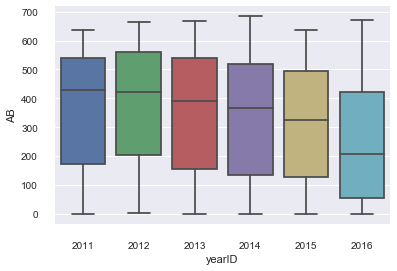

In [26]:
%matplotlib inline
sns.boxplot(x="yearID",y="AB",data=hitters)
sns.despine(offset=10, trim=True)

I'm going to set the maximum penalty at 50 at bats, meaning those with less than 50 at bats will get their star ratings penalized most heavily. I'll end the penalties at 300 at bat, meaning those with 300 or more at bats will not be penalized at all. I'll apply the penalty as an adjustment factor:

$P = 1$ if $AB \ge 300$, $P = 0.1$ if $AB < 50$, and $P = 0.1 + \frac{AB-50}{300}*1.08$ otherwise.

In [27]:
def applyPenalty(x):
    if (x < 50):
        return 0.1
    elif (x >= 300):
        return 1
    else:
        return (0.1 + 1.08* ((x-50)/300))

In [28]:
hitters['Penalty'] = hitters['AB'].apply(applyPenalty)

In [29]:
# Briefly check for reasonability
hitters[['AB','Penalty']].head(20)

,AB,Penalty
0,556.0,1.0000
1,613.0,1.0000
2,624.0,1.0000
3,52.0,0.1072
4,61.0,0.1396
5,15.0,0.1000
6,53.0,0.1108
7,225.0,0.7300
8,86.0,0.2296
9,296.0,0.9856


## Calculate star ratings
This is easy: $\textit{Stars} = (HR + BA + R + RBI + SB) * P$, where the five terms being summed are the indexed values, and $P$ is the adjustment factor.

In [30]:
hitters.columns

Index(['playerID', 'yearID', 'LastOfteamID', 'nameFirst', 'nameLast', 'weight',
       'height', 'bats', 'lgID', 'G', 'H', 'AB', 'HR', 'RBI', 'SB', 'R', '2B',
       '3B', 'CS', 'BB', 'SO', 'IBB', 'HBP', 'SH', 'SF', 'GIDP', 'G_p', 'G_c',
       'G_1b', 'G_2b', 'G_3b', 'G_ss', 'G_lf', 'G_cf', 'G_rf', 'G_of', 'G_dh',
       'debut', 'birthCountry', 'prim_pos', 'other_pos', 'BA', 'OBP', '1B',
       'SLG', 'OPS', 'BA_Scaled', 'HR_Scaled', 'R_Scaled', 'RBI_Scaled',
       'SB_Scaled', 'Penalty'],
      dtype='object')

In [31]:
hitters['AdjStars'] = hitters['Penalty']*(hitters['HR_Scaled'] + hitters['R_Scaled'] + hitters['RBI_Scaled'] + hitters['SB_Scaled'] + hitters['BA_Scaled'])

Let's look at the top 10 star performers in the league for 2016.

In [32]:
hitters2016 = hitters[hitters['yearID']==2016].sort_values('AdjStars', axis=0, ascending=False)

In [33]:
hitters2016.head(10)

,playerID,yearID,LastOfteamID,nameFirst,nameLast,weight,height,bats,lgID,G,...,1B,SLG,OPS,BA_Scaled,HR_Scaled,R_Scaled,RBI_Scaled,SB_Scaled,Penalty,AdjStars
113,bettsmo01,2016,BOS,Mookie,Betts,180,69,R,AL,158.0,...,136.0,0.534226,0.897240,0.477679,0.659574,0.991870,0.849624,0.419355,1.0,3.398102
1377,troutmi01,2016,LAA,Mike,Trout,235,74,R,AL,159.0,...,107.0,0.550091,0.990620,0.472678,0.617021,1.000000,0.751880,0.483871,1.0,3.325450
59,arenano01,2016,COL,Nolan,Arenado,205,74,R,NL,160.0,...,100.0,0.569579,0.931648,0.441748,0.872340,0.943089,1.000000,0.032258,1.0,3.289435
368,doziebr01,2016,MIN,Brian,Dozier,200,71,R,AL,155.0,...,83.0,0.546341,0.885964,0.402439,0.893617,0.845528,0.744361,0.290323,1.0,3.176268
174,bryankr01,2016,CHN,Kris,Bryant,230,77,R,NL,155.0,...,99.0,0.553897,0.938733,0.437811,0.829787,0.983740,0.766917,0.129032,1.0,3.147288
37,altuvjo01,2016,HOU,Jose,Altuve,165,66,R,AL,161.0,...,145.0,0.531250,0.927609,0.506250,0.510638,0.878049,0.721805,0.483871,1.0,3.100613
412,encared01,2016,TOR,Edwin,Encarnacion,230,73,R,AL,160.0,...,82.0,0.529118,0.885752,0.394343,0.893617,0.804878,0.954887,0.032258,1.0,3.079983
363,donaljo02,2016,TOR,Josh,Donaldson,210,73,R,AL,155.0,...,90.0,0.549393,0.953405,0.426343,0.787234,0.991870,0.744361,0.112903,1.0,3.062711
1412,villajo01,2016,MIL,Jonathan,Villar,215,73,B,NL,156.0,...,108.0,0.456706,0.826142,0.427844,0.404255,0.747967,0.473684,1.000000,1.0,3.053751
522,goldspa01,2016,ARI,Paul,Goldschmidt,225,75,R,NL,158.0,...,112.0,0.488774,0.899285,0.445596,0.510638,0.861789,0.714286,0.516129,1.0,3.048438


## Write out the results of this exercise

In [36]:
# Top 50 overall
hitters2016[0:49].to_csv("./output/top50.csv", header=True)

In [37]:
# Top 25 at each (primary) position
for pos in gamescols[1:]:
    pos = pos[2:]
    filename = "./output/top25" + pos + ".csv"
    hitters2016[hitters2016['prim_pos'] == pos].to_csv(filename, header=True)

## Outstanding issues

* Include 'years of service' as a predictor?
* What do we do with DH? (Maybe consider them at alternate positions for which they are eligible)

# Pitchers
This one is a bit harder. We may have nine pitchers active at any one time. The five statistics for pitchers will be:

* ERA
* SO
* Saves
* Wins
* WHIP = (walks + hits) / innings pitched

It's difficult to get a single score because wins and strikeouts will be low for relievers, because they face fewer batters and by definition do not as often find themselves in positions to qualify for a win under league conventions. Similarly, saves will be low (should be zero, except for exceptional circumstances) for starters. I therefore calculate two additional statistics from the Lahman data:

* Batters faced per game - should be high for starters and low (<= 9) for relievers
* Games started / games appeared in, which should again be 1 for most starters and low for most relievers.

These will be checks against my two indices for pitchers, the *starter index* and the *reliever index*. Each statistic within these indices will be indexed to 1, in the same way that the five hitter statistics were. The two indices will be composed as follows:

* Starter index: ERA + SO + Wins + WHIP
* Reliever index: ERA + WHIP + Saves

I'll build separate top lists for each one.

## Wouldn't it be nice...
... if we could just take the combinations of 9 pitchers that maximized team rank in these areas. However, there are ${814 \choose 9} = 4.13 \times 10^{20}$ such combinations, which would take freaking forever to search through. This will have to be good enough.